### I work in Albertsons, the second-largest supermarket chain in North America. On our eCommerce platform, we often need to track patterns across the life-cycle of our customers, decide their stickiness, and adjust marketing strategies to specific groups of users. Cohort analysis is a useful tool to segment customers based on their usages of our platform. How you group your users depends on your business model. As a consumer-goods company, purchases are at the core of our business, so I do a lot of cohort analyses based on certain metrics from customers' first orders. 

### In this article, I will give an example of cohort analysis based on a customer's first order amount. I would like to see if the amount of a customer's first order could be an indicator of their stickiness. In order to answer this question, I divided customers into cohort groups based on their first order amount, and then tracked the cumulative retention rate based on customers' second orders within 180 days of their first orders. 

### You can find the dataset here: http://dmanalytics.org/wp-content/uploads/2014/10/chapter-12-relay-foods.xlsx (I also highly recommend Greg Reda's blog: http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/ which is a classic example of how to do cohort analysis based on customers' first purchase date and track customers' retention rate over time. I used the same dataset here.) 

### Let's import necessary libraries and dataset first.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

orders = pd.read_excel('chapter-12-relay-foods.xlsx',sheet_name='Purchase Data - Full Study')
orders.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


### I will sort the dataset by customers and their order dates, so I can add a column to indicate their order sequence.

In [3]:
orders.sort_values(by=['UserId','OrderDate'],ascending=[True,True],inplace=True)
orders['NthOrder'] = orders.groupby(['UserId']).cumcount()+1
orders.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,NthOrder
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,1
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,3
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,4
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,5


### Check the distribution of customers' first order amount. 

0.0      1.39000
0.2     15.66400
0.4     27.34832
0.6     44.31600
0.8     70.74200
1.0    690.98270
Name: TotalCharges, dtype: float64


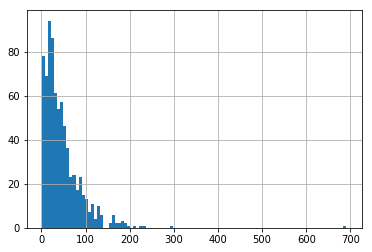

In [4]:
first_order = orders[orders['NthOrder']==1]
print(first_order['TotalCharges'].quantile(q=[0,0.2,0.4,0.6,0.8,1]))
first_order['TotalCharges'].hist(bins=100);

### We can see most consumers in this dataset ordered something below 50 for their first orders. Now let's flag the customers based on their first order amount.

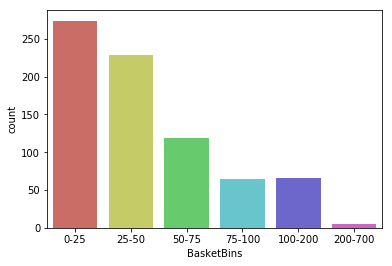

In [5]:
labels = ['0-25','25-50','50-75','75-100','100-200','200-700']                   
first_order['BasketBins'] = pd.cut(first_order['TotalCharges'], [0,25,50,75,100,200,700], labels=labels)
sns.countplot(first_order['BasketBins'], palette="hls"); 

### I will create a dataframe to hold the numbers of new users in each cohort group for later use. 

In [6]:
users = pd.DataFrame(first_order.groupby(['BasketBins'])['UserId'].count())
users.rename(columns={'UserId': 'TotalUsers'},inplace=True)
users

,TotalUsers
BasketBins,
0-25,274
25-50,228
50-75,119
75-100,65
100-200,66
200-700,5


### In the original dataset, add one column for each customer's first order date and another column for how many days have passed since their first orders. 

In [7]:
orders['FirstOrderDate'] = orders.groupby('UserId')['OrderDate'].transform('min')
orders['OrderInterval'] = (orders['OrderDate'] - orders['FirstOrderDate']).apply(lambda x: x.days) 
orders.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,NthOrder,FirstOrderDate,OrderInterval
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,1,2009-01-11,0
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2,2009-01-11,9
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,3,2009-01-11,23
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,4,2009-01-11,26
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,5,2009-01-11,26


### Now I want to create a series of labels to indicated order periods: 0 always means the first order date for a customer. If OrderPeriod = 1, it means the order was made within 1-7 days of the customer's first order. If OrderPeriod = 2, it means the order was made within 8-14 days of the customer's first order.    

In [8]:
# I am only interested in the first 180 days within each customer's first purchase. So I only created labels till 180. 
binedges = np.arange(-7,180,7)   
binlabels = np.arange(0,26,1)   
   
orders['OrderPeriod'] = pd.cut(orders['OrderInterval'], binedges, labels = binlabels)
# Orders outside the 180-day order interval will be null. Remove them.
orders.dropna(inplace=True)

orders.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,NthOrder,FirstOrderDate,OrderInterval,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,1,2009-01-11,0,0
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2,2009-01-11,9,2
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,3,2009-01-11,23,4
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,4,2009-01-11,26,4
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,5,2009-01-11,26,4


### Now let me create the cumulative retention rate for the first cohort group, who spent $0-25 for their first order.  

In [9]:
label = labels[0]
# Get the list of customers who spend $0-25 in their first order.
cust = first_order[first_order['BasketBins']==label]['UserId'].unique().tolist()

# Retrieve orders for this group of people and label them as 0-25 group.
df = orders[orders['UserId'].isin(cust)]
df['CohortGroup'] = label

# Further retrieve these people's second orders.    
df = df[df['NthOrder']==2]
df.sort_values(by=['CohortGroup','OrderPeriod'], ascending=[True,True], inplace=True)
    
# How many users are in each CohortGroup and OrderPeriod.
df = df.groupby(['CohortGroup','OrderPeriod'])['UserId'].count().reset_index()
df.head()

,CohortGroup,OrderPeriod,UserId
0,0-25,0,1
1,0-25,1,24
2,0-25,2,21
3,0-25,3,7
4,0-25,4,6


### So for customers who spent 0-25 for their first order, 1 customer placed a second order on the same day. 24 people placed their second orders within 1-7 days following their first orders. 21 customers placed their second orders within 8-14 days following their second orders. 

### I want to see the cumulative user counts during different periods following their first purchases. 

In [10]:
df['cum_user'] = df.groupby(['CohortGroup'])['UserId'].cumsum()
    
df.set_index(['CohortGroup', 'OrderPeriod'], inplace=True)
cum_user = df['cum_user'].unstack(0).T 
cum_user

OrderPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,19,24
CohortGroup,,,,,,,,,,,,,,,,,,,
0-25,1,25,46,53,59,72,73,76,78,81,82,85,86,87,88,89,90,91,92


### Now we can see that at the end of period 24 (162-168 days following first order), 92 people from group 0-25 have placed a second order. If you scroll up and look at the users dataframe we created earlier, you will see that there are 274 people in group 0-25, meaning 274 people in our dataset has made a first order around $0-25. So at the end of 180-day period, 92/274 = 33.6% of these customers have placed a second order.

### Now let's iterate through all the labels and produce the cumulative retention rate for each group.

In [11]:
for l in labels[1:len(labels)]:
    label = l
    cust = first_order[first_order['BasketBins']==l]['UserId'].unique().tolist()
    df = orders[orders['UserId'].isin(cust)]
    df['CohortGroup'] = label      
        
    df = df[df['NthOrder']==2]
    df.sort_values(by=['CohortGroup','OrderPeriod'], ascending=[True,True], inplace=True)
        
    df = df.groupby(['CohortGroup','OrderPeriod'])['UserId'].count().reset_index()
    df['cum_user'] = df.groupby(['CohortGroup'])['UserId'].cumsum()
        
    df.set_index(['CohortGroup', 'OrderPeriod'], inplace=True)
    cum_user2 = df['cum_user'].unstack(0).T
    cum_user = pd.concat([cum_user,cum_user2])      

In [12]:
cum_user

OrderPeriod,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
CohortGroup,,,,,,,,,,,,,,,,,,,,,
0-25,1.0,25,46,53.0,59,72.0,73.0,76.0,78.0,81.0,...,89.0,90.0,NaN,91.0,NaN,NaN,NaN,NaN,92.0,NaN
25-50,2.0,53,79,91.0,99,100.0,105.0,108.0,110.0,113.0,...,NaN,127.0,128.0,NaN,129.0,NaN,130.0,NaN,NaN,131.0
50-75,4.0,24,35,42.0,47,53.0,55.0,56.0,59.0,60.0,...,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75-100,NaN,7,18,21.0,27,33.0,34.0,NaN,NaN,NaN,...,NaN,NaN,39.0,NaN,NaN,40.0,41.0,42.0,NaN,NaN
100-200,6.0,14,31,42.0,43,44.0,NaN,45.0,46.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200-700,NaN,2,3,NaN,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We will get the percentage of users who placed a second order in different periods by dividing the cumulative user counts by their initial group size, which is stored in dataframe users. 

In [13]:
cum_user2 = cum_user.divide(users['TotalUsers'],axis=0)
cum_user2

OrderPeriod,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
CohortGroup,,,,,,,,,,,,,,,,,,,,,
0-25,0.003650,0.091241,0.167883,0.193431,0.215328,0.262774,0.266423,0.277372,0.284672,0.295620,...,0.324818,0.328467,NaN,0.332117,NaN,NaN,NaN,NaN,0.335766,NaN
25-50,0.008772,0.232456,0.346491,0.399123,0.434211,0.438596,0.460526,0.473684,0.482456,0.495614,...,NaN,0.557018,0.561404,NaN,0.565789,NaN,0.570175,NaN,NaN,0.574561
50-75,0.033613,0.201681,0.294118,0.352941,0.394958,0.445378,0.462185,0.470588,0.495798,0.504202,...,NaN,NaN,0.554622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75-100,NaN,0.107692,0.276923,0.323077,0.415385,0.507692,0.523077,NaN,NaN,NaN,...,NaN,NaN,0.600000,NaN,NaN,0.615385,0.630769,0.646154,NaN,NaN
100-200,0.090909,0.212121,0.469697,0.636364,0.651515,0.666667,NaN,0.681818,0.696970,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200-700,NaN,0.400000,0.600000,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We can further add the total user counts for each group to be more clear. 

In [14]:
result = users.join(cum_user2)
result

,TotalUsers,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
BasketBins,,,,,,,,,,,,,,,,,,,,,
0-25,274,0.003650,0.091241,0.167883,0.193431,0.215328,0.262774,0.266423,0.277372,0.284672,...,0.324818,0.328467,NaN,0.332117,NaN,NaN,NaN,NaN,0.335766,NaN
25-50,228,0.008772,0.232456,0.346491,0.399123,0.434211,0.438596,0.460526,0.473684,0.482456,...,NaN,0.557018,0.561404,NaN,0.565789,NaN,0.570175,NaN,NaN,0.574561
50-75,119,0.033613,0.201681,0.294118,0.352941,0.394958,0.445378,0.462185,0.470588,0.495798,...,NaN,NaN,0.554622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75-100,65,NaN,0.107692,0.276923,0.323077,0.415385,0.507692,0.523077,NaN,NaN,...,NaN,NaN,0.600000,NaN,NaN,0.615385,0.630769,0.646154,NaN,NaN
100-200,66,0.090909,0.212121,0.469697,0.636364,0.651515,0.666667,NaN,0.681818,0.696970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200-700,5,NaN,0.400000,0.600000,NaN,0.800000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Let's make some charts to make this information easier to digest. 

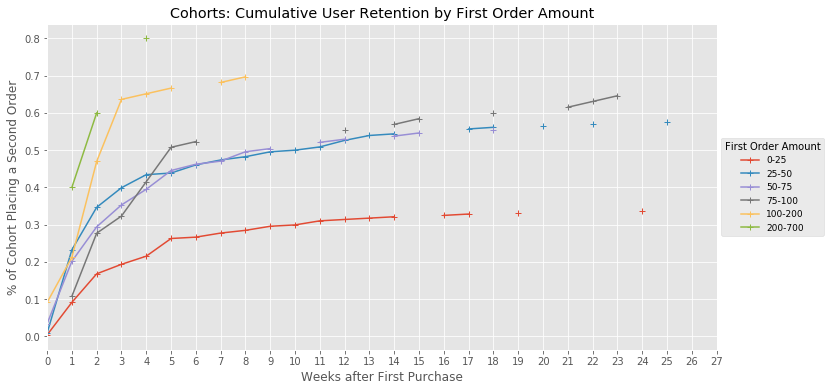

In [15]:
plt.style.use('ggplot')
chart_data = result.drop(['TotalUsers'],1).T

chart_data.plot(figsize=(12,6),marker='+')
plt.title('Cohorts: Cumulative User Retention by First Order Amount')
plt.xticks(np.arange(0, 27.1, 1))
plt.xlim(0, 27)
plt.xlabel("Weeks after First Purchase")
plt.ylabel('% of Cohort Placing a Second Order')
plt.legend(title="First Order Amount", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9);

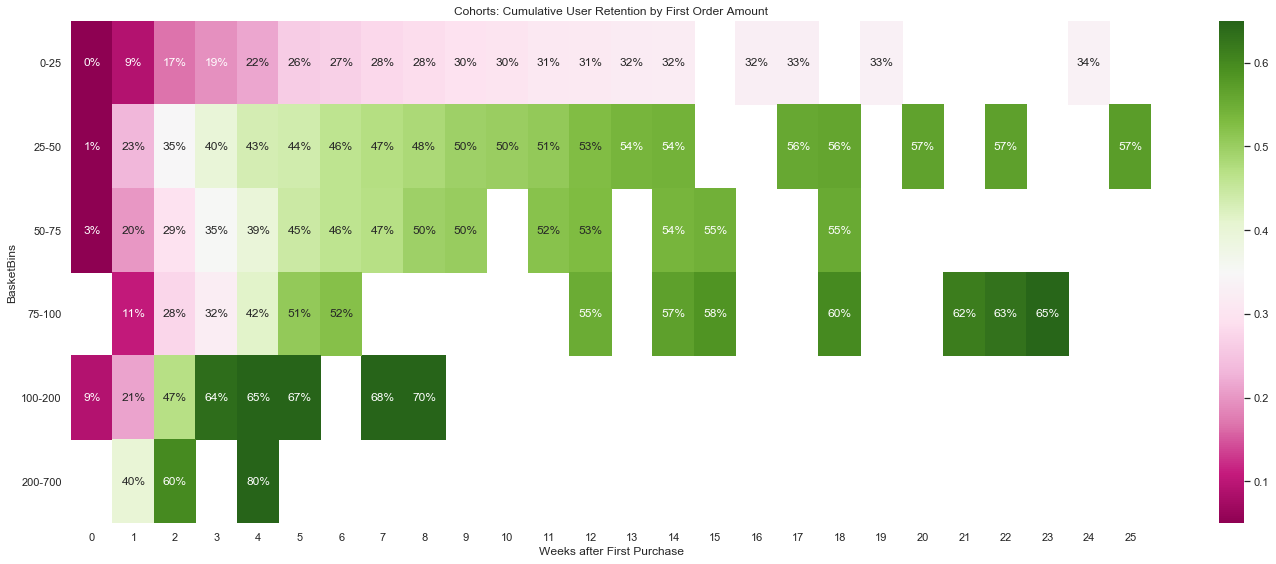

In [16]:
sns.set(style='white')

plt.figure(figsize=(20, 8))
plt.title('Cohorts: Cumulative User Retention by First Order Amount')
sns.heatmap(result.drop(['TotalUsers'],1), mask=result.drop(['TotalUsers'],1).isnull(), \
            annot=True, fmt='.0%', vmin=0.05, vmax=0.65, cmap = "PiYG")
plt.xlabel('Weeks after First Purchase')
plt.yticks(rotation=0)
plt.tight_layout();

### From the chart, we can see clearly see that people who spent less on their first orders tend to be one-time customers. At the end of 180-day period within their first purchases, only 34% of the initial group have come back and make a second purchase. People who spent more on their first orders showed more stickiness. 

### Of course, this is only one aspect of the story. To get the whole picture, it will be useful to combine this cumulative retention rate with the traditional user retention rate (e.g. the example in Greg Reda's post). The result may vary based on your business. I got some interesting results when I used this method to analyze our eCommerce customers. Try it on your own customers and see what facts it reveals!  